### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [2]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [3]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [5]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4790)
Training epoch 20
Error tensor(0.2216)
Training epoch 40
Error tensor(0.2178)


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [6]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.038200308


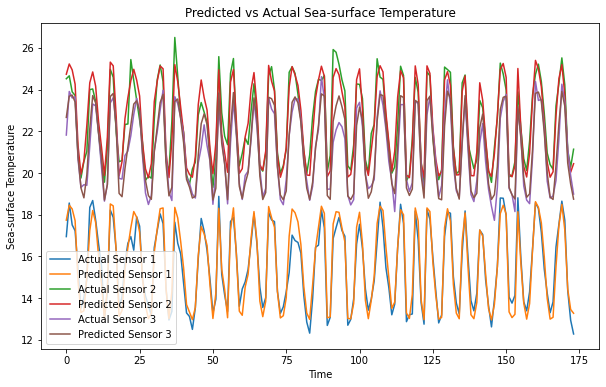

In [9]:
# Generate predictions on the test dataset if the model was trained successfully
if 'shred' in locals():
    with torch.no_grad():
        shred.eval()
        test_predictions = shred(test_dataset[:][0])

    # Inverse transform the predictions and actual values
    test_predictions = sc.inverse_transform(test_predictions.cpu().numpy())
    test_actual = sc.inverse_transform(test_dataset[:][1])

    # Plot the predicted and actual values for each sensor location
    num_sensor_locations = len(sensor_locations)
    plt.figure(figsize=(10, 6))
    for i in range(num_sensor_locations):
        plt.plot(test_actual[:, sensor_locations[i]], label=f'Actual Sensor {i+1}')
        plt.plot(test_predictions[:, sensor_locations[i]], label=f'Predicted Sensor {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Sea-surface Temperature')
    plt.title('Predicted vs Actual Sea-surface Temperature')
    plt.legend()
    plt.show()
else:
    print("The SHRED model is not available.")

In [ ]:
lags_values = [10, 20, 30, 40, 50, 60]  # Example lag values to test

performance = []  # List to store performance metric values

for lags_val in lags_values:
    num_sensors = 3 
    lags = 52
    load_X = load_data('SST')
    load_X = load_X[lags_val:]
    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    # Append the performance metric to the list
    performance.append(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# Plot the performance metric as a function of lags
plt.plot(lags_values, performance, marker='o')
plt.xlabel('Lags')
plt.ylabel('Performance Metric')
plt.title('Performance Metric as a Function of Lags')
plt.show()

In [ ]:
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3]  # Example noise levels to test

performance = []  # List to store performance metric values

for noise_level in noise_levels:
    num_sensors = 3 
    lags = 52
    load_X = load_data('SST')
    # Add Gaussian noise to the transformed data
    noisy_transformed_X = transformed_X + np.random.normal(loc=0, scale=noise_level, size=transformed_X.shape)

    n = noisy_transformed_X.shape[0]
    m = noisy_transformed_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    # Append the performance metric to the list
    performance.append(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# Plot the performance metric as a function of noise levels
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, performance)
plt.xlabel('Noise Levels')
plt.ylabel('Performance Metric')
plt.title('Performance Metric as a Function of Noise Levels')
plt.show()

In [ ]:
sensor_values = [2, 3, 4, 5, 6]  # Example sensor values to test

performance = []  # List to store performance metric values

for sensor_val in sensor_values:
    # Update the num_sensors parameter
    num_sensors = sensor_val
    lags = 52
    load_X = load_data('SST')
    load_X = load_X[lags_val:]
    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    # Append the performance metric to the list
    performance.append(1/(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))


# Plot the performance metric as a function of sensor values
plt.figure(figsize=(10, 6))
plt.plot(sensor_values, performance)
plt.xlabel('Number of Sensors')
plt.ylabel('Performance Metric')
plt.title('Performance Metric as a Function of Number of Sensors')
plt.show()